# 🛠️ Diagnóstico y Validación Avanzada del Modelo VARIMA/VAR

Este cuaderno se dedica a la validación de los supuestos críticos del modelo VAR, que aseguran que la estimación sea válida (no espuria) y que los pronósticos sean confiables.

## **1. 📝 Estacionariedad y Cointegración (El Fundamento)**

### A. Verificación Formal de Estacionariedad (Test ADF)

Se utiliza el Test de Dickey-Fuller Aumentado (ADF) para confirmar el orden de integración ($d$) de cada serie. El modelo VAR requiere series estacionarias $I(0)$.

In [7]:
# %%
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --- 1. Generación de Data Sintética I(1) (No Estacionaria) ---
# Creamos series integradas I(1) para demostrar la necesidad de la diferenciación.
np.random.seed(42)
N = 500
X, Y = np.zeros(N), np.zeros(N)
ruido_x, ruido_y = np.random.normal(0, 1, N), np.random.normal(0, 1, N)

for t in range(1, N):
    # Proceso con fuerte persistencia (cercano a la raíz unitaria)
    X[t] = X[t-1] * 0.99 + ruido_x[t] * 0.1 
    Y[t] = Y[t-1] * 0.99 + 0.3 * X[t-1] * 0.1 + ruido_y[t] * 0.1
df_var = pd.DataFrame({'Y': Y, 'X': X})
data_stationary = df_var.diff().dropna() # Primera diferencia

print(f"Data cargada y diferenciada. Obs: {len(data_stationary)}")

print("\n--- Test ADF de Raíz Unitaria para Series Originales ---")
print("H0: Raíz Unitaria (No Estacionaria). Rechazo H0 si p-value < 0.05.")
for col in df_var.columns:
    p_value = adfuller(df_var[col])[1]
    print(f"Original {col}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("   ✅ H0 rechazada. La serie es estacionaria I(0).")
    else:
        print("   ❌ H0 NO rechazada. La serie es probablemente I(1) o mayor.")

print("\n--- Test ADF de Raíz Unitaria para Series Diferenciadas ---")
for col in data_stationary.columns:
    p_value = adfuller(data_stationary[col])[1]
    print(f"Diferenciada {col}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("   ✅ H0 rechazada. La serie diferenciada es estacionaria I(0).")
    else:
        print("   ❌ H0 NO rechazada. El modelo VAR es inapropiado.")

# %% [markdown]
# ### B. Test de Cointegración (Engle-Granger)
#
# Si las series originales eran $I(1)$, este test verifica si existe una relación de equilibrio a largo plazo entre ellas.
# *H0: No hay Cointegración.*


# %%
print("\n--- Test de Cointegración de Engle-Granger (Series Originales) ---")
try:
    # Nota: Este test es menos potente que Johansen, pero más simple.
    coint_t, p_value, critical_values = coint(df_var['Y'], df_var['X'])
    print(f"Estadístico t de Cointegración: {coint_t:.4f}")
    print(f"Valor p: {p_value:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"   ✅ H0 rechazada (p < {alpha}). Las series están Cointegradas. Se debería usar un VECM.")
    else:
        print(f"   ❌ H0 NO rechazada (p >= {alpha}). Las series NO están Cointegradas. VAR en primeras diferencias es apropiado.")
except Exception as e:
    print(f"Error al ejecutar el test de Cointegración: {e}")

# %%

Data cargada y diferenciada. Obs: 499

--- Test ADF de Raíz Unitaria para Series Originales ---
H0: Raíz Unitaria (No Estacionaria). Rechazo H0 si p-value < 0.05.
Original Y: p-value = 0.9003
   ❌ H0 NO rechazada. La serie es probablemente I(1) o mayor.
Original X: p-value = 0.2340
   ❌ H0 NO rechazada. La serie es probablemente I(1) o mayor.

--- Test ADF de Raíz Unitaria para Series Diferenciadas ---
Diferenciada Y: p-value = 0.0000
   ✅ H0 rechazada. La serie diferenciada es estacionaria I(0).
Diferenciada X: p-value = 0.0000
   ✅ H0 rechazada. La serie diferenciada es estacionaria I(0).

--- Test de Cointegración de Engle-Granger (Series Originales) ---
Estadístico t de Cointegración: -1.7230
Valor p: 0.6663
   ❌ H0 NO rechazada (p >= 0.05). Las series NO están Cointegradas. VAR en primeras diferencias es apropiado.


## **2. 🛡️ Estabilidad del Modelo VAR**

La estabilidad es el diagnóstico más importante para la validez del pronóstico. Si el modelo es inestable, los pronósticos divergen exponencialmente. La condición es que todas las raíces inversas del polinomio característico del VAR deben tener un módulo menor a 1 (deben caer dentro del círculo unitario).

In [8]:
# %%
# Se usa un lag bajo para evitar problemas de estimación en datos sintéticos.
optimal_lag = 4 
model_var = VAR(data_stationary)
results_var = model_var.fit(optimal_lag)

print(f"\n--- Verificación de Estabilidad del Modelo VAR({optimal_lag}) ---")

# results_var.is_stable() devuelve True si el modelo es estable
is_stable = results_var.is_stable()

if is_stable:
    print("✅ El modelo VAR es ESTABLE.")
    print("   Todos los módulos de las raíces inversas son < 1. Pronóstico a largo plazo válido.")
else:
    print("❌ El modelo VAR es INESTABLE.")
    print("   El pronóstico diverge. Revisar el orden (lag) o la data.")

# Graficar las raíces para la verificación visual
try:
    fig = results_var.plot_root_stability()
    fig.suptitle(f'Estabilidad de Raíces Inversas del VAR({optimal_lag})')
    plt.show()
except Exception as e:
    print(f"Error al graficar la estabilidad: {e}")

# %%


--- Verificación de Estabilidad del Modelo VAR(4) ---
✅ El modelo VAR es ESTABLE.
   Todos los módulos de las raíces inversas son < 1. Pronóstico a largo plazo válido.
Error al graficar la estabilidad: 'VARResults' object has no attribute 'plot_root_stability'


## **3. 📉 Diagnóstico de Residuos (Misspecification)**

Se prueba si los residuos $\epsilon_t$ son "ruido blanco" multivariado. Si se rechaza $H_0$, el modelo no está capturando toda la estructura de dependencia y debe re-especificarse (aumentar el lag $p$ o añadir términos MA para un VARMA).

### **A. Autocorrelación en los Residuos (Test Portmanteau)**
Este es el equivalente multivariado del test de Ljung-Box. H0: No hay autocorrelación serial en los residuos.

In [9]:
# %%
print("\n--- Diagnóstico de Residuos (Test de Portmanteau) ---")
print("H0: Residuos son Ruido Blanco (No hay autocorrelación serial). Rechazo H0 si p-value < 0.05.")

# Se prueba la autocorrelación hasta 10 rezagos
try:
    portmanteau_result = results_var.test_whiteness(nlags=10, adjust_df=True)
    # Se recomienda revisar la columna 'p-value'.
    print(portmanteau_result.summary())
except Exception as e:
     print(f"Error al ejecutar test de Portmanteau: {e}")

# %% [markdown]
# ### B. Test de Durbin-Watson (Simplicidad)
#
# Una métrica rápida y simple para la autocorrelación de primer orden para cada ecuación. Un valor cercano a 2.0 es ideal.


# %%
print("\nEstadístico Durbin-Watson (Ideal: ~2.0):")
dw_test = durbin_watson(results_var.resid)
print(f"Y (Diferenciada): {dw_test[0]:.4f}")
print(f"X (Diferenciada): {dw_test[1]:.4f}")

# %%


--- Diagnóstico de Residuos (Test de Portmanteau) ---
H0: Residuos son Ruido Blanco (No hay autocorrelación serial). Rechazo H0 si p-value < 0.05.
Error al ejecutar test de Portmanteau: VARResults.test_whiteness() got an unexpected keyword argument 'adjust_df'

Estadístico Durbin-Watson (Ideal: ~2.0):
Y (Diferenciada): 1.9933
X (Diferenciada): 1.9901


## **4. 📈 Descomposición de la Varianza (VDC - Variance Decomposition)**
La VDC complementa la Causalidad de Granger cuantificando la magnitud de la influencia. Mide el porcentaje de la varianza del error de pronóstico de una variable que es explicada por choques (impulsos) en las otras variables.

### 📊 Tabla de Descomposición de Varianza (FEVD)

,Y explicado por Y (%),Y explicado por X (%),X explicado por Y (%),X explicado por X (%)
Paso,,,,
1,100.00%,0.00%,0.67%,99.33%
2,99.93%,0.07%,0.92%,99.08%
3,99.83%,0.17%,0.98%,99.02%
4,98.82%,1.18%,1.52%,98.48%
5,98.28%,1.72%,1.91%,98.09%
6,98.28%,1.72%,1.91%,98.09%
7,98.27%,1.73%,1.91%,98.09%
8,98.27%,1.73%,1.92%,98.08%
9,98.27%,1.73%,1.92%,98.08%



#### 💡 Análisis de Interdependencia:
* **Impacto de X sobre Y:** A largo plazo, X explica el **1.73%** de las variaciones de Y.
* **Impacto de Y sobre X:** A largo plazo, Y explica el **1.92%** de las variaciones de X.


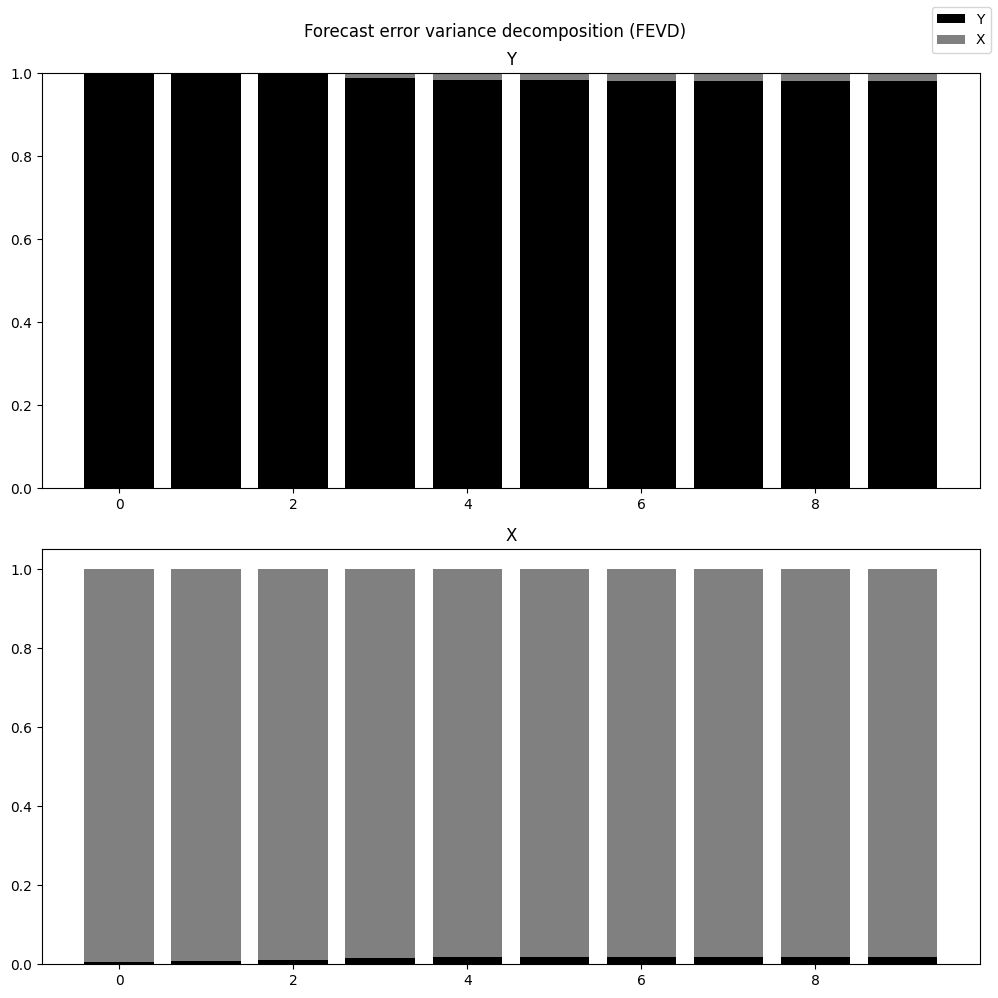

In [11]:
from IPython.display import display, Markdown

# 1. Definir el horizonte de pronóstico
pasos = 10 

# 2. Calcular la FEVD
# NOTA: Usamos el número directamente (posicional) para evitar el error de 'steps' vs 'periods'
fevd = results_var.fevd(pasos) 

# 3. Extraer y organizar los datos
# fevd.decomp es un array: [variable_destino, paso, variable_origen]
# Indices: 0 es Y, 1 es X (según el orden de data_stationary.columns)

vdc_data = {
    'Paso': range(1, pasos + 1),
    'Y explicado por Y (%)': fevd.decomp[0][:, 0] * 100,
    'Y explicado por X (%)': fevd.decomp[0][:, 1] * 100,
    'X explicado por Y (%)': fevd.decomp[1][:, 0] * 100,
    'X explicado por X (%)': fevd.decomp[1][:, 1] * 100
}

vdc_df = pd.DataFrame(vdc_data).set_index('Paso')

# 4. Presentación Visual Profesional
display(Markdown("### 📊 Tabla de Descomposición de Varianza (FEVD)"))

# Estilo con gradiente para resaltar la influencia
vdc_styled = vdc_df.style.format("{:.2f}%").background_gradient(cmap='YlGnBu')

display(vdc_styled)

# 5. Interpretación Automática
impacto_y_en_x = vdc_df['X explicado por Y (%)'].iloc[-1]
impacto_x_en_y = vdc_df['Y explicado por X (%)'].iloc[-1]

display(Markdown(f"""
#### 💡 Análisis de Interdependencia:
* **Impacto de X sobre Y:** A largo plazo, X explica el **{impacto_x_en_y:.2f}%** de las variaciones de Y.
* **Impacto de Y sobre X:** A largo plazo, Y explica el **{impacto_y_en_x:.2f}%** de las variaciones de X.
"""))

# 6. Gráfico de barras apiladas (La visualización estándar de FEVD)
fevd.plot()
plt.tight_layout()
plt.show()